# Transfer Learning with VGG16 on MNIST

## Objective
To evaluate and visualize how the feature extraction capability of a **VGG16** model (pretrained on **ImageNet**) changes **before and after transfer learning** on the **MNIST** digit dataset.

---

## Methodology

- **Data Preparation**:
  - Resized grayscale MNIST images from `28x28` to `224x224`.
  - Converted images to 3-channel RGB to match VGG16 input format.
  - Used a subset of 1000 training samples for faster experimentation.

- **Model Setup**:
  - Imported **VGG16** with `weights='imagenet'` and `include_top=False`.
  - Added new layers:
    - `GlobalAveragePooling2D`
    - `Dense(256, activation='relu')`
    - `Dense(10, activation='softmax')`
  - The base VGG16 model was **frozen** during training.

- **Training**:
  - Optimizer: Adam
  - Loss: Categorical Crossentropy
  - Epochs: 5
  - Validation split: 20%

---

## Import Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

2025-06-22 01:52:45.242725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750535565.308477   83203 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750535565.327198   83203 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750535565.446975   83203 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750535565.446996   83203 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750535565.446998   83203 computation_placer.cc:177] computation placer alr

## Load and normalize data

In [2]:
(x_train, y_train), _ = mnist.load_data()

## Process the data

In [ ]:
def preprocess_images(images, batch_size = 500):
  resized = []
  for i in range(0, len(images), batch_size):
    batch = images[i:i+batch_size]
    batch = tf.expand_dims(batch, -1)
    batch = tf.image.resize(batch, (224, 224))
    batch = tf.image.grayscale_to_rgb(batch)
    resized.append(batch)
  return tf.concat(resized, axis=0)

x_train = preprocess_images(x_train[:300])
y_train = to_categorical(y_train[:300], num_classes=10)

2025-06-22 01:53:41.367007: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-06-22 01:53:41.518953: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 180633600 exceeds 10% of free system memory.


## Load VGG16 as base model

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze pretrained layers

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5


2025-06-22 01:58:36.895504: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-06-22 01:58:37.166960: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-06-22 01:58:37.921253: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-06-22 01:58:38.000836: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


8/8 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - accuracy: 0.1764 - loss: 4.3258 - val_accuracy: 0.5333 - val_loss: 1.6336
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - accuracy: 0.6850 - loss: 1.0438 - val_accuracy: 0.6500 - val_loss: 0.9957
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.8444 - loss: 0.5216 - val_accuracy: 0.8333 - val_loss: 0.6630
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.9535 - loss: 0.2163 - val_accuracy: 0.8500 - val_loss: 0.5512
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 56s 7s/step - accuracy: 0.9468 - loss: 0.1756 - val_accuracy: 0.8667 - val_loss: 0.5565


## Feature Extraction

- **Before Transfer Learning**:
  - Extracted features from VGG16's convolutional base with `GlobalAveragePooling2D`.

- **After Transfer Learning**:
  - Extracted features from the fully connected `Dense(256)` layer of the trained model.


In [10]:
feature_extractor_before = Model(inputs=model.input, outputs=model.layers[-3].output)
features_before = feature_extractor_before.predict(x_train)

feature_extractor_after = Model(inputs=model.input, outputs=model.layers[-1].output)
features_after = feature_extractor_after.predict(x_train)

10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step


## Plot the features & visualization

To understand how well the model learned feature representations, three techniques were applied:

1. **PCA (Principal Component Analysis)**
2. **t-SNE (t-distributed Stochastic Neighbor Embedding)**
3. **UMAP (Uniform Manifold Approximation and Projection)**

In [11]:
def plot_reduction(X, y, method, title):
    plt.figure(figsize=(8, 6))
    for i in range(10):
        idxs = (y == i)
        plt.scatter(X[idxs, 0], X[idxs, 1], label=str(i), alpha=0.6)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

## PCA Visualization

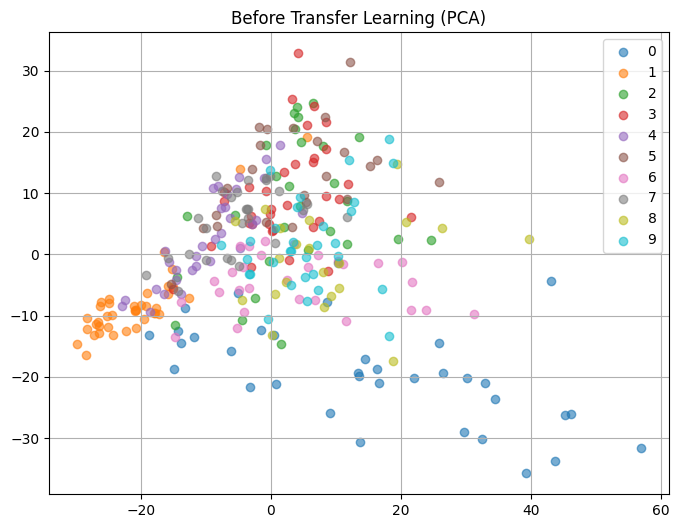

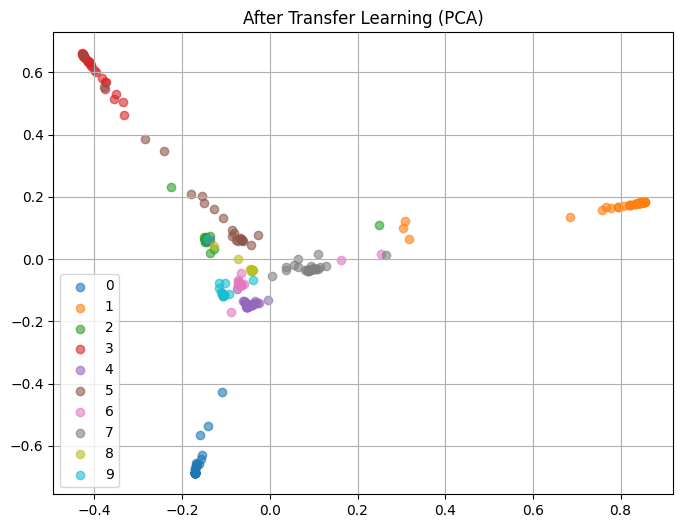

In [17]:
pca_before = PCA(n_components=2)
pca_after = PCA(n_components=2)
features_before_2d = pca_before.fit_transform(features_before.reshape(len(features_before), -1))
features_after_2d = pca_after.fit_transform(features_after.reshape(len(features_after), -1))
plot_reduction(features_before_2d, y_train[:300].argmax(axis=1), 'PCA', 'Before Transfer Learning (PCA)')
plot_reduction(features_after_2d, y_train[:300].argmax(axis=1), 'PCA', 'After Transfer Learning (PCA)')

## TSNE Visualization

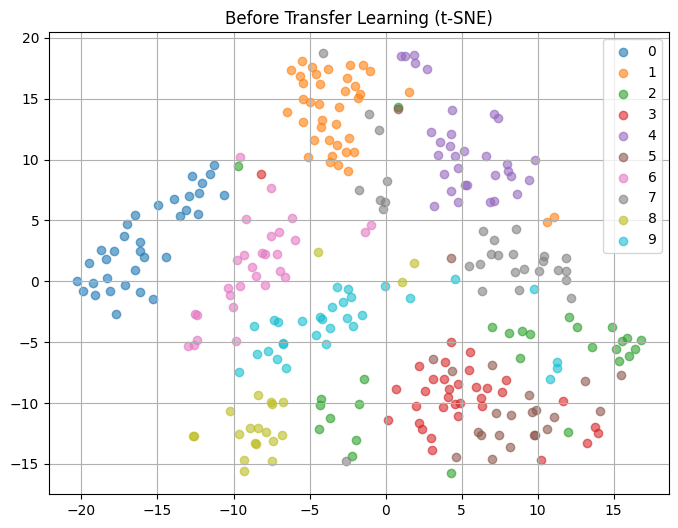

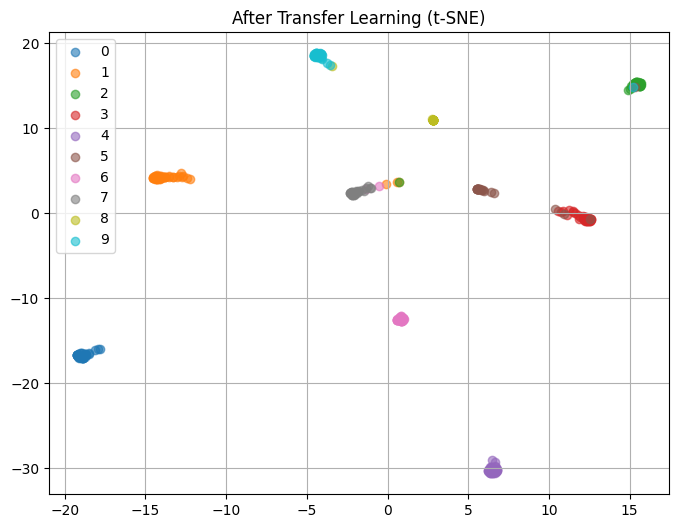

In [18]:
tsne_before = TSNE(n_components=2)
tsne_after = TSNE(n_components=2)
features_before_2d_tsne = tsne_before.fit_transform(features_before.reshape(len(features_before), -1))  
features_after_2d_tsne = tsne_after.fit_transform(features_after.reshape(len(features_after), -1))
plot_reduction(features_before_2d_tsne, y_train[:300].argmax(axis=1), 't-SNE', 'Before Transfer Learning (t-SNE)')
plot_reduction(features_after_2d_tsne, y_train[:300].argmax(axis=1), 't-SNE', 'After Transfer Learning (t-SNE)')

## UMAP Visualization

/home/rayhanul/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rayhanul/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


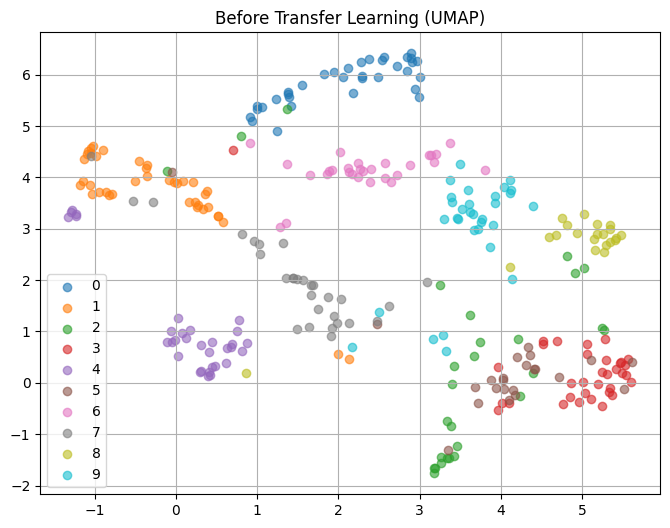

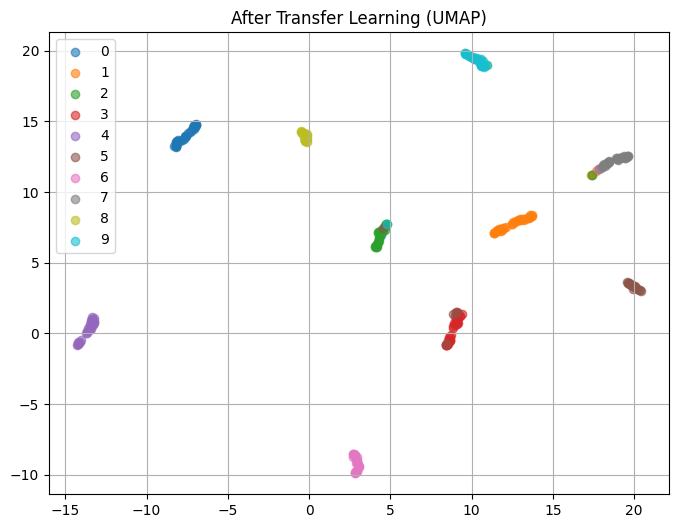

In [19]:
umap_before = umap.UMAP(n_components=2)
umap_after = umap.UMAP(n_components=2)
features_before_2d_umap = umap_before.fit_transform(features_before.reshape(len(features_before), -1))
features_after_2d_umap = umap_after.fit_transform(features_after.reshape(len(features_after), -1))
plot_reduction(features_before_2d_umap, y_train[:300].argmax(axis=1), 'UMAP', 'Before Transfer Learning (UMAP)')
plot_reduction(features_after_2d_umap, y_train[:300].argmax(axis=1), 'UMAP', 'After Transfer Learning (UMAP)')

## Conclusion

- Features **after transfer learning** showed clearer class separability in 2D space.
- VGG16 successfully transferred useful representations to the MNIST domain despite differing source data.
- This validates the effectiveness of transfer learning in improving feature quality and downstream performance.
